<a href="https://colab.research.google.com/github/mmihaiceanu/DataSet/blob/master/GroupProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

In [2]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder

from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

In [4]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [5]:
!pip install -U -q PyDrive 
  
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)


Import the test dataset

In [6]:
link_test='https://drive.google.com/file/d/17i9TxFAur6fv7vwr1C2eNYpDi1OM9G-c/view'
# to get the id part of the file 
id_test = link_test.split("/")[-2] 
  
downloaded_test = drive.CreateFile({'id':id_test})  
downloaded_test.GetContentFile('test.csv')   
  
df_test = pd.read_csv('test.csv') 
#print(df)
df_test.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B


Import the train set

In [7]:
link_train = 'https://drive.google.com/file/d/1kvysfS4SQ-xhEXf8Qgf-rtUKAjeEBtPh/view'

# to get the id part of the file 
id_train = link_train.split("/")[-2] 
  
downloaded_train = drive.CreateFile({'id':id_train})  
downloaded_train.GetContentFile('train.csv')   
  
df = pd.read_csv('train.csv') 
#print(df)
df.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trip                 38999 non-null  object 
 1   date                 38999 non-null  object 
 2   dayPart              38999 non-null  object 
 3   exWeatherTag         4882 non-null   object 
 4   originLocation       38999 non-null  object 
 5   destinationLocation  38999 non-null  object 
 6   distance             38999 non-null  int64  
 7   type                 3748 non-null   object 
 8   weight               38999 non-null  int64  
 9   packageType          2500 non-null   object 
 10  carrier              38999 non-null  object 
 11  cost                 38999 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 3.6+ MB


In [9]:
## format datetime column
df["date"] = pd.to_datetime(df['date'])

In [10]:
df.describe()

,distance,weight,cost
count,38999.000000,38999.000000,38999.000000
mean,2004.061643,42.293033,80.972210
std,728.996843,75.473752,180.715055
min,400.000000,1.000000,5.000000
25%,1400.000000,13.000000,38.768742
50%,2000.000000,25.000000,46.468476
75%,2600.000000,39.000000,70.239797
max,3600.000000,500.000000,2019.734797


In [11]:
df_train=df.copy()

Split the date column into three columns: Year, Monts and Day

In [12]:
split_by_date=df_train['date'].astype(str).apply(lambda x: list(map(int, x.split('-'))))

In [13]:
split_by_date

0          [2017, 9, 6]
1        [2017, 10, 21]
2         [2017, 7, 15]
3        [2017, 10, 22]
4        [2019, 12, 11]
              ...      
38994    [2019, 10, 17]
38995     [2019, 1, 23]
38996     [2018, 10, 3]
38997     [2018, 2, 26]
38998     [2017, 7, 30]
Name: date, Length: 38999, dtype: object

In [14]:
split_by_date_val=split_by_date.values
split_by_date_val

array([list([2017, 9, 6]), list([2017, 10, 21]), list([2017, 7, 15]), ...,
       list([2018, 10, 3]), list([2018, 2, 26]), list([2017, 7, 30])],
      dtype=object)

In [15]:
split_by_date_stack=np.vstack(split_by_date_val)
split_by_date_stack

array([[2017,    9,    6],
       [2017,   10,   21],
       [2017,    7,   15],
       ...,
       [2018,   10,    3],
       [2018,    2,   26],
       [2017,    7,   30]])

In [16]:
df_train['Year']=split_by_date_stack[:,0]
df_train['Year']

0        2017
1        2017
2        2017
3        2017
4        2019
         ... 
38994    2019
38995    2019
38996    2018
38997    2018
38998    2017
Name: Year, Length: 38999, dtype: int64

In [17]:
df_train['Month']=split_by_date_stack[:,1]

In [18]:
df_train['Day']=split_by_date_stack[:,2]

In [19]:
df_train.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost,Year,Month,Day
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152,2017,9,6
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649,2017,10,21
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939,2017,7,15
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087,2017,10,22
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777,2019,12,11


Check the null values

In [20]:
count_nulls=df_train.isnull().sum().sort_values(ascending=False)
count_nulls

packageType            36499
type                   35251
exWeatherTag           34117
Day                        0
Month                      0
Year                       0
cost                       0
carrier                    0
weight                     0
distance                   0
destinationLocation        0
originLocation             0
dayPart                    0
date                       0
trip                       0
dtype: int64

Calculate the percentage of missing values

In [21]:
percentage=round(count_nulls/len(df)*100, 2)
percentage

packageType            93.59
type                   90.39
exWeatherTag           87.48
Day                     0.00
Month                   0.00
Year                    0.00
cost                    0.00
carrier                 0.00
weight                  0.00
distance                0.00
destinationLocation     0.00
originLocation          0.00
dayPart                 0.00
date                    0.00
trip                    0.00
dtype: float64

In [118]:
# create a table that shows the number of missing values and the percentage
pd.concat([count_nulls, percentage], axis=1, keys=['Number of nulls','Percent'])

,Number of nulls,Percent
packageType,36499,93.59
type,35251,90.39
exWeatherTag,34117,87.48
Day,0,0.00
Month,0,0.00
Year,0,0.00
cost,0,0.00
carrier,0,0.00
weight,0,0.00
distance,0,0.00


We can drop packageType, type and exWeather because they are missing more than 80% of the information

In [119]:
df_train_copy=df_train.copy()

In [120]:
df_train_copy = df_train_copy.drop(['trip','date','originLocation','destinationLocation','exWeatherTag','type','packageType', 'Year'],axis=1)

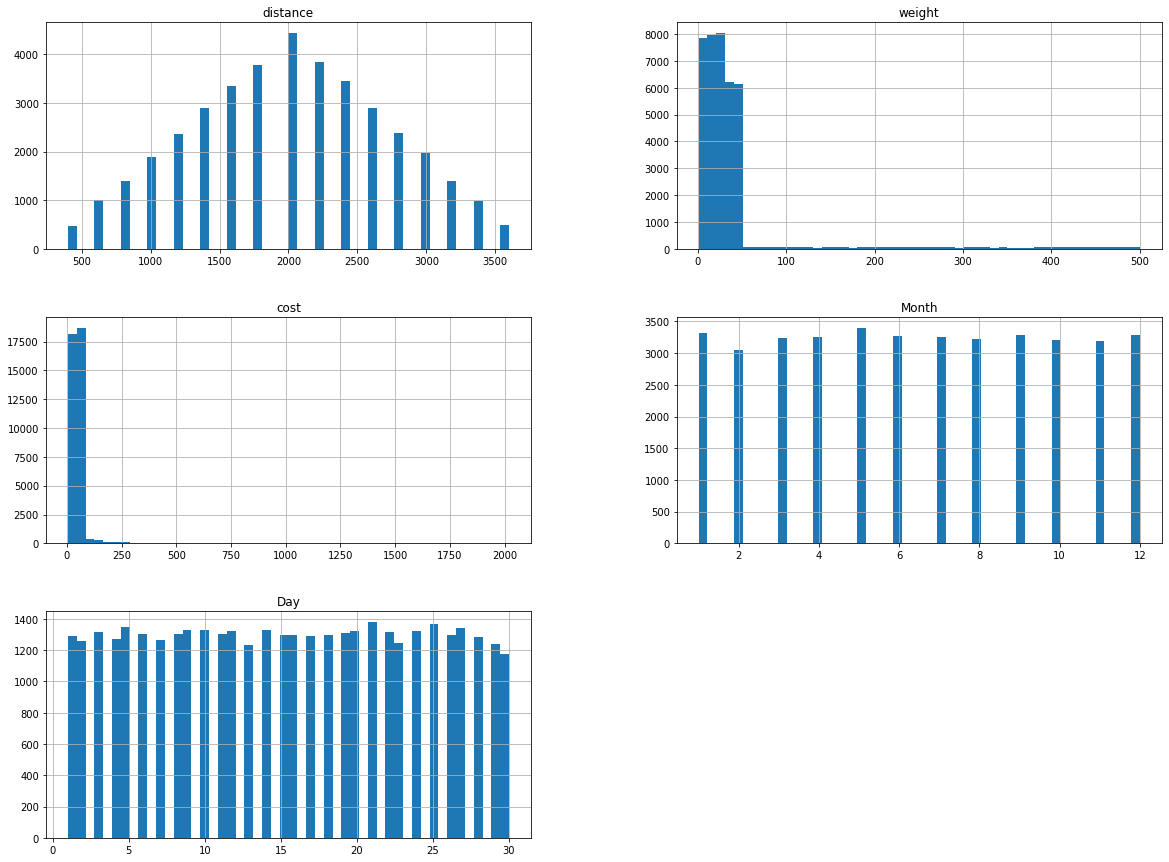

In [121]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train_copy.hist(bins=50, figsize=(20,15))
plt.show()

In [122]:
corr_matrix = df_train_copy.corr()
corr_matrix

,distance,weight,cost,Month,Day
distance,1.000000,-0.004986,0.006427,0.000988,0.005368
weight,-0.004986,1.000000,0.859548,-0.003634,-0.006104
cost,0.006427,0.859548,1.000000,-0.008062,-0.003918
Month,0.000988,-0.003634,-0.008062,1.000000,0.015740
Day,0.005368,-0.006104,-0.003918,0.015740,1.000000


In [123]:
corr_matrix['cost'].sort_values(ascending=False)

cost        1.000000
weight      0.859548
distance    0.006427
Day        -0.003918
Month      -0.008062
Name: cost, dtype: float64

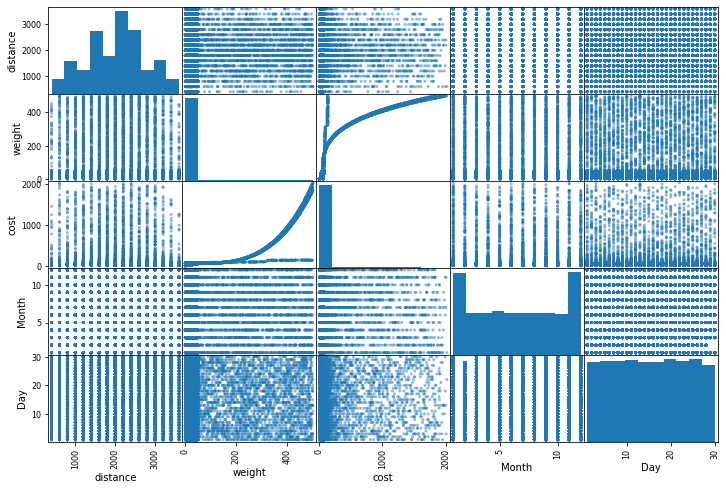

In [124]:
from pandas.plotting import scatter_matrix

attributes = ['distance','weight', 'cost', 'Month', 'Day']

scatter_matrix(df_train_copy[attributes], figsize=(12, 8));

### Feature Engineering


Remove the text attribute because median can only be calculated on numerical attributes:

In [125]:
df_train_num = df_train_copy.drop(columns=["dayPart", "carrier"], axis=1)

In [126]:
df_train_num.head()

,distance,weight,cost,Month,Day
0,2200,50,68.413152,9,6
1,1800,12,36.450649,10,21
2,2800,1,9.057939,7,15
3,3200,50,57.320087,10,22
4,2000,43,77.263777,12,11


Preprocessing the categorical feature, "dayPart":

In [128]:
dayPart_cat=df_train_copy[['dayPart']]
dayPart_cat.head()

,dayPart
0,night
1,night
2,night
3,day
4,day


Preprocessing the categorial feature, "carrier"

In [129]:
carrier_cat=df_train_copy[['carrier']]
carrier_cat.head()

,carrier
0,D
1,B
2,B
3,C
4,B


In [62]:
#Replace dayPart values with 0 and 1
#df['dayPart'].replace(['day','night'],[1,0],inplace=True)

In [ ]:
#cat_encoder = OneHotEncoder(sparse=False)
#day_part_cat_hot = cat_encoder.fit_transform(day_part)
#day_part_cat_hot

In [ ]:
#cat_encoder.categories_

**Create the training and validation sets**

In [179]:
train_set, val_set = train_test_split(df_train_copy, test_size=0.1, shuffle=False, random_state=42)

In [180]:
# X variables
train_set_X = train_set.drop("cost", axis=1)
val_set_X = val_set.drop("cost", axis=1)

# Y Variable
train_set_y = train_set["cost"].copy()
val_set_y = val_set["cost"].copy()


In [181]:
train_set_X.head()

,dayPart,distance,weight,carrier,Month,Day
0,night,2200,50,D,9,6
1,night,1800,12,B,10,21
2,night,2800,1,B,7,15
3,day,3200,50,C,10,22
4,day,2000,43,B,12,11


In [182]:
val_set_X.head()

,dayPart,distance,weight,carrier,Month,Day
35099,night,2400,43,B,4,24
35100,day,2000,49,B,10,29
35101,night,2400,45,B,7,21
35102,day,2000,34,B,4,2
35103,night,800,18,A,1,26


In [183]:
train_set_X_num=train_set_X.drop(columns=["dayPart", "carrier"], axis=1)

In [184]:
train_set_X_num.head()

,distance,weight,Month,Day
0,2200,50,9,6
1,1800,12,10,21
2,2800,1,7,15
3,3200,50,10,22
4,2000,43,12,11


In [185]:
val_set_X_num=val_set_X.drop(columns=['dayPart', 'carrier'], axis=1)

In [186]:
val_set_X_num.head()

,distance,weight,Month,Day
35099,2400,43,4,24
35100,2000,49,10,29
35101,2400,45,7,21
35102,2000,34,4,2
35103,800,18,1,26


In [187]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

**Creating the piplines**

In [188]:
cat_pipeline = Pipeline([
        ("selector", DataFrameSelector(['carrier'])),
        ("cat_encoder", CategoricalEncoder(encoding='onehot-dense')),
    ])

num_pipeline = Pipeline([
        ("selector", DataFrameSelector(['distance','weight'])),
        ('std_scaler', MinMaxScaler()),
      ])

no_pipeline = Pipeline([
        ("selector", DataFrameSelector(["dayPart","Month","Day"]))
    ])

y_pipeline = Pipeline([
        ("selector", DataFrameSelector(['cost'])),
        ('std_scaler', StandardScaler()),
      ])

**Full pipeline**

In [189]:
full_pipeline_old = FeatureUnion(transformer_list=[
    ("no_pipeline", no_pipeline),
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
    ])


Pipline for numerical attributes

In [190]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([("selector", DataFrameSelector(['distance','weight'])),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

df_num = num_pipeline.fit_transform(train_set_X_num)

In [191]:
list(train_set_X_num.columns)

['distance', 'weight', 'Month', 'Day']

Pipeline for non-numerical attributes

In [199]:
non_num_pipeline=Pipeline([("selector", DataFrameSelector(['Month', 'Day']))])

Pipeline for categorical attributes

In [201]:
categorical_pipeline=Pipeline([("selector", DataFrameSelector(["dayPart", "carrier"])),
                               ("categ", OneHotEncoder())])

In [204]:
from sklearn.compose import ColumnTransformer

num_attribs = ['distance','weight']#list(train_set_X_num.columns)
cat_attribs = ["dayPart", "carrier"]
nonnum_attribs=['Month', 'Day']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("nonum", non_num_pipeline, nonnum_attribs),
        ("cat", categorical_pipeline, cat_attribs)
    ])

df_prepared = full_pipeline.fit_transform(train_set_X)

In [205]:
df_prepared

array([[ 2.67720837e-01,  1.00343378e-01,  9.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.81169823e-01, -4.01317846e-01,  1.00000000e+01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.09105683e+00, -5.46535569e-01,  7.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.30060482e-01,  7.93210000e-03,  2.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-8.30060482e-01, -3.22108179e-01,  1.20000000e+01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.72449311e-03, -4.67325902e-01,  1.10000000e+01, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [206]:
df_prepared_toDF = pd.DataFrame(df_prepared)

In [155]:
#df_train_copy#

In [207]:
df_prepared_toDF.head()

,0,1,2,3,4,5,6,7,8,9
0,0.267721,0.100343,9.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.281170,-0.401318,10.0,21.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.091057,-0.546536,7.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.639947,0.100343,10.0,22.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.006724,0.007932,12.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0


In [208]:
final_train_X = full_pipeline.fit_transform(train_set_X)
final_val_X = full_pipeline.transform(val_set_X)

final_train_y = y_pipeline.fit_transform(pd.DataFrame(train_set_y))
final_val_y = y_pipeline.transform(pd.DataFrame(val_set_y))

In [209]:
df1=pd.DataFrame(final_train_X)
df1.head()

,0,1,2,3,4,5,6,7,8,9
0,0.267721,0.100343,9.0,6.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.281170,-0.401318,10.0,21.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.091057,-0.546536,7.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.639947,0.100343,10.0,22.0,1.0,0.0,0.0,0.0,1.0,0.0
4,-0.006724,0.007932,12.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0


### Select and train the model

In [210]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(final_train_X, final_train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)